#### Load required libraries

In [1]:
import numpy as np
import logging
import pickle
from scipy import sparse
from scipy.linalg import block_diag
import scipy.io as spio

# Define color and marker for analysis plots
markers = ["x", "+", "o"]
colors = ["blue","orange","green","red","purple","brown","pink"]

#import os.path
import os
from os import path

from pathlib import Path
# import DOS library
import dos
import dos.plot_tools as ptools

from ruamel import yaml
from ruamel.yaml import YAML
y = YAML()
y.default_flow_style = None

sim_folder = 'dos/SH_AcO'
calibDataFolder = '/Users/rromano/Workspace/SIMCEO/calibration_dbs'

In [11]:
# Reload plot tools library
import importlib
importlib.reload(dos.plot_tools)

<module 'dos.plot_tools' from '/Users/rromano/Workspace/SIMCEO/dos/plot_tools.py'>

In [12]:
# Reload DOS library
import importlib
importlib.reload(dos.tools)

<module 'dos.tools' from '/Users/rromano/Workspace/SIMCEO/dos/tools.py'>

#### Load interaction matrix

In [2]:
# Calibrations data
#dt = np.load(Path(calibDataFolder)/'calib_dt_SH0p5fluxTH_46BM.npz', allow_pickle=True)
dt = np.load(Path(calibDataFolder)/'calib_dt_GSH0p5fluxTH_46BM.npz', allow_pickle=True)


#### AcO reconstructor+controller settings

In [19]:
# *** Reconstructor tuning settings ***

# Number of bending modes
n_bm = 27

# Consolidate SH-WFS interaction matrices of all segments
Dsh = block_diag(*[Dseg[:,:12+n_bm] for Dseg in dt['calibdt'][()]['D'][:-1]])
Dsh = block_diag(Dsh,dt['calibdt'][()]['D'][-1][:,:10+n_bm])

max_Fz = 147
K, rho_2, rho_3 = 0.25, 1.0, 1.0

# Bending modes' data
Afz = {}
# OA segment weights
filepath = os.path.join('../ActiveOptics','Af_oa_axial_ver3.mat')
Afz['outer'] = spio.loadmat(filepath)['afprime']
_U,s_oa,V_oaT = np.linalg.svd(Afz['outer'],0)
bm2Fz_oa = np.dot(V_oaT.T, np.diag(1/s_oa)[:,:n_bm])
# CS (center segment) weights
filepath = os.path.join('../ActiveOptics','Af_cs154_axial.mat')
Afz['center'] = spio.loadmat(filepath)['afprime']
_U,s_cs,V_csT = np.linalg.svd(Afz['center'],0)
bm2Fz_cs = np.dot(V_csT.T, np.diag(1/s_cs)[:,:n_bm])

# RBM data
max_m1RBM = [3.0e-3,4.75e-3,4e-3] + [6.5e-4,5.75e-4,5.75e-4]
max_m2RBM = [3.0e-5,3.0e-5,3.0e-5] + [3.5e-3,3.5e-3,3.5e-3]

rbm_ranges = max_m1RBM+max_m2RBM
oa_ranges = np.array(rbm_ranges + [max_Fz]*bm2Fz_oa.shape[0])
cs_ranges = np.array(rbm_ranges + [max_Fz]*bm2Fz_cs.shape[0])

umax = np.hstack([np.kron(np.array([1]*6),oa_ranges),cs_ranges]) # np.array([]) #
umin = -umax
_Tu = block_diag(np.kron(np.eye(6),block_diag(np.eye(12),bm2Fz_oa)),
                 block_diag(np.eye(12),bm2Fz_cs))

# AcO dictionary
# Removing the filed J1_J3_ratio sets the (baseline) TSVD reconstructor
# npred = 0 set linear integral control
data = {'SHAcO':{'D':Dsh,'n_bm':n_bm,'W2':[],'W3':[],
                 'K':K,'rho_2':rho_2,'rho_3':rho_3,
                 'wfsMask':dt['calibdt'][()]['wfsMask'],
                 'A':0,'B':1,
                 'Q':sparse.csc_matrix(1),'R':sparse.csc_matrix(1),'npred':0,
                 'umin':umin, 'umax':umax,'_Tu':_Tu}}
# Pickles MPC data into string representation
with open(Path(sim_folder)/'SHAcO.pickle','wb') as f:
    pickle.dump(data,f)
    

In [4]:
# # Check reconstructors 
# M_rls = dos.tools.build_RLS_RecM(Dsh, W2, W3=1.0e-3*W3, K=K, rho_2=np.sqrt(1), rho_3=rho_3, insM1M2S7Rz=True)
# M_rls = M_rls[:,:-273]
# M_tsvd = dos.tools.build_TSVD_RecM(Dsh, n_r=12, insM1M2S7Rz=True)
# M = dos.tools.build_AcO_Rec(dt['calibdt'][()]['D'],n_bm=n_bm,rec_alg='TSVD')
# print(np.linalg.norm(M_rls-M), np.linalg.norm(M_tsvd-M))

# dt1 = np.diag(M_rls.dot(M_rls.T))[:39]
# dt2 = np.diag(M_tsvd.dot(M_tsvd.T))[:39]
# dt3 = np.diag(M.dot(M.T))[:39]
# plt.figure(figsize=(16,6))
# #plt.plot(100*np.abs(dt3-dt1)/dt3,'s')
# #plt.plot(100*np.abs(dt3-dt2)/dt3,'+')
# plt.semilogy(dt1,'s')
# plt.semilogy(dt2,'.')
# plt.semilogy(dt3,'x')

#### Set ray tracing and WFS parameters

In [20]:
GSmag = 0
with open(Path(sim_folder)/'wfs48.yaml','r') as stream:
        wfs48_dt = yaml.safe_load(stream)
# Set guide star magnitude
wfs48_dt['source']['magnitude'] = (GSmag*np.array([1,1,1])).tolist()
print('Magnitude:',wfs48_dt['source']['magnitude'])
with open(Path(sim_folder)/'wfs48.yaml','w') as f:
    y.dump(wfs48_dt, f)        

Magnitude: [0, 0, 0]


#### Set initial M1/M2 states and generate respective yaml files

In [21]:
# Python code to set simulation states
from ruamel import yaml
from ruamel.yaml import YAML
m1m2load_folder = 'testDT/M1M2_loads'
r_id = 1

test_case = 'random' # 'random_RBM' # 'BM_dist' #

if(test_case == 'BM_dist'):
    fileSTR = '_2_3bm'
elif(test_case == 'random_RBM'):
    fileSTR = '_rand_rbm_%d' %r_id
elif(test_case == 'random'):
    fileSTR = '_rbmplusbm_%d' %r_id
else:
    fileSTR = '_noload' %r_id

print(fileSTR)

with open(Path(m1m2load_folder)/('M1'+fileSTR+'.yaml'),'r') as f:
    m1_x0_dt = yaml.safe_load(f)
with open(Path(m1m2load_folder)/('M2'+fileSTR+'.yaml'),'r') as f:
    m2_x0_dt = yaml.safe_load(f)
    
# Update yaml files with M1/M2 initial conditions    
with open(Path(sim_folder)/'M1.yaml','w') as f:
        y.dump(m1_x0_dt, f)
with open(Path(sim_folder)/'M2.yaml','w') as f:
        y.dump(m2_x0_dt, f)
    

_rbmplusbm_1


In [22]:
if not (umax.shape[0]):
    filename = 'test%s_GS%d_K%sTSVDwosat.pickle'% (fileSTR,GSmag,str(K).replace(".", "p"))
else:
    filename = 'test%s_GS%d_K%sTSVD.pickle'% (fileSTR,GSmag,str(K).replace(".", "p"))
filename

'test_rbmplusbm_1_GS0_K0p25TSVD.pickle'

In [23]:
sim = dos.DOS(sim_folder,verbose=logging.WARNING,show_timing=2)

INFO:wfs48 data:Linked to data from wfs48
INFO:M1 Txyz:Linked to Txyz from M1
INFO:M1 Rxyz:Linked to Rxyz from M1
INFO:M2 Txyz:Linked to Txyz from M2
INFO:M2 Rxyz:Linked to Rxyz from M2
INFO:M1 BM:Linked to modes from M1


SIMCEO server received: Acknowledging connection from SIMCEO client!
27 BMs used in the reconstructor computation.
No J1_J3_ratio informed. Using TSVD reconstructor


#### Instantiate DOS

In [24]:
# Start simulation
#sim.start()
sim._run_()

Number of clipping iterations:1
Number of clipping iterations:1
Number of clipping iterations:1
Number of clipping iterations:1
Number of clipping iterations:1
Number of clipping iterations:1
Number of clipping iterations:1
Number of clipping iterations:1
Number of clipping iterations:1
Number of clipping iterations:1
Number of clipping iterations:1
Number of clipping iterations:1
Number of clipping iterations:7
Number of clipping iterations:7
Number of clipping iterations:6
Number of clipping iterations:10
Number of clipping iterations:7
Number of clipping iterations:10
Number of clipping iterations:8
Number of clipping iterations:7
Number of clipping iterations:10
Number of clipping iterations:8
Number of clipping iterations:8
Number of clipping iterations:8
Number of clipping iterations:10
Number of clipping iterations:9
Number of clipping iterations:11
Number of clipping iterations:8
Number of clipping iterations:9
Number of clipping iterations:7
Number of clipping iterations:7
Num

### Image quality metrics

In [16]:
sim.logs

The 'logs' has 12 entries:
 * wfs48
   1. M12_RBM: (273,)x100
 * SHAcO
   1. M1 Txyz: (7, 3)x100
   2. M1 Rxyz: (7, 3)x100
   3. M2 Txyz: (7, 3)x100
   4. M2 Rxyz: (7, 3)x100
   5. M1 BM: (7, 27)x100
 * science
   1. wfe_rms: (1,)x100
   2. segment_wfe_rms: (7,)x100
   3. PSSn: (1,)x100
   4. tiptilt: (2,)x100
   5. segment_piston: (7,)x100
   6. segment_tiptilt: (14,)x100

In [17]:
print(sim.logs.entries['science']['wfe_rms'].timeSeries[1][0,:]*1.0e9)
print('Seg WFE RMS:\n',sim.logs.entries['science']['segment_wfe_rms'].timeSeries[1][0,:]*1.0e9)

[5916.89877183]
Seg WFE RMS:
 [2039.7001208  4239.04884883 2914.79432235 3886.75107388 3892.09571949
 3626.94277101 4308.13997809]


Save test results into date file

In [25]:
if(0):
    sim_log_dt = {'sim_log_dt':sim.logs.entries}
    with open(Path('testDT')/filename,'wb') as f:
            pickle.dump(sim_log_dt,f)

(Random) RBM load test - Baseline reconstructor without saturation $k_i=0.25$ (without noise)


Final values:
 WFE (nm): [ 1.06394] 
 [ 0.76924  0.77482  0.77486  0.77060  0.77753  0.77121  0.17256] 
PSSn: [ 1.00000] 
sum of abs seg piston (um): 0.007327978598925533 
 [-0.00224 -0.00066 -0.00015 -0.00222 -0.00088 -0.00070 -0.00047]


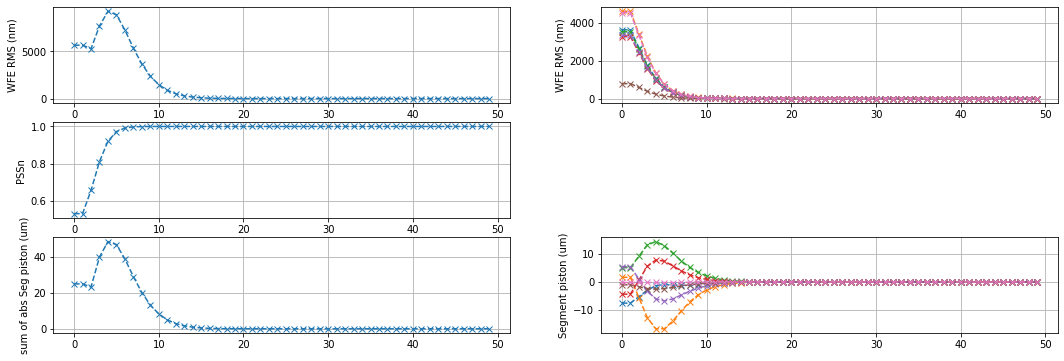

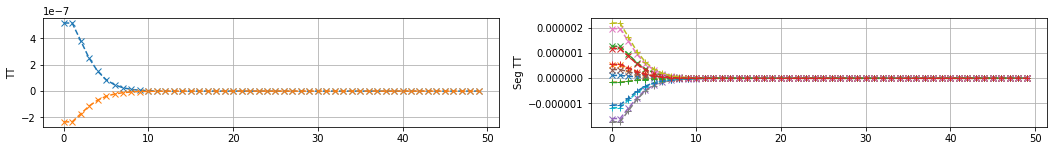

In [16]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

 (Random) RBM load test - Baseline reconstructor with saturation $k_i=0.25$ (without noise)


Final values:
 WFE (nm): [ 4709496.16283] 
 [ 2448334.12580  2524232.95751  1827149.18628  445263.63490  1556180.18471
  1960468.47850  3266248.85201] 
PSSn: [ 0.24633] 
sum of abs seg piston (um): 25033.13877969049 
 [ 3165.37591  4253.61935 -1712.65914 -1743.23202 -6922.28554  428.65166
  6807.31516]


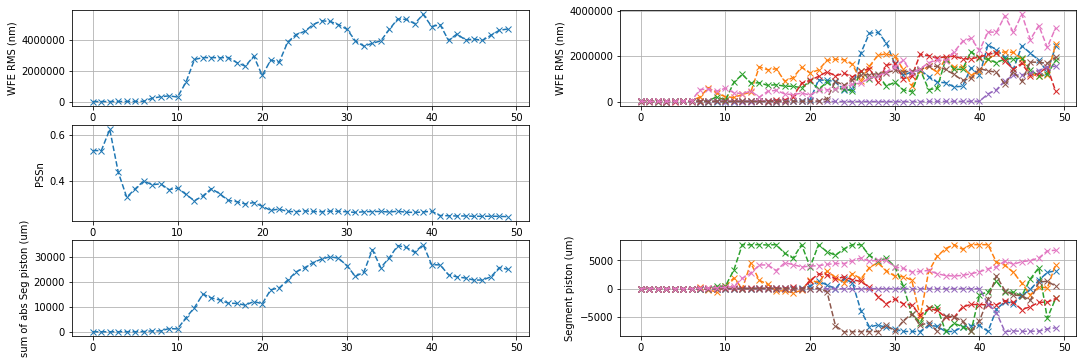

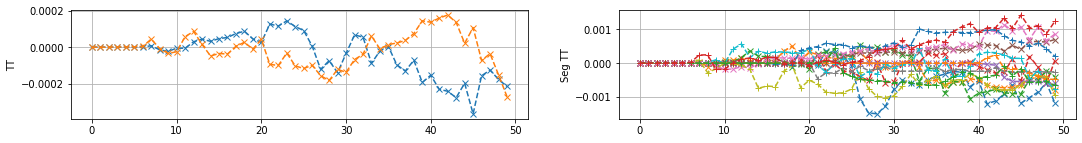

In [9]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

Bending mode load test - Baseline reconstructor without saturation $k_i=0.25$ (without noise)


Final values:
 WFE (nm): [ 0.84401] 
 [ 0.77149  0.77170  0.77180  0.77283  0.77255  0.77125  0.17258] 
PSSn: [ 1.00000] 
sum of abs seg piston (um): 0.0029881060958913963 
 [ 0.00048 -0.00049 -0.00016  0.00045 -0.00022 -0.00073 -0.00045]


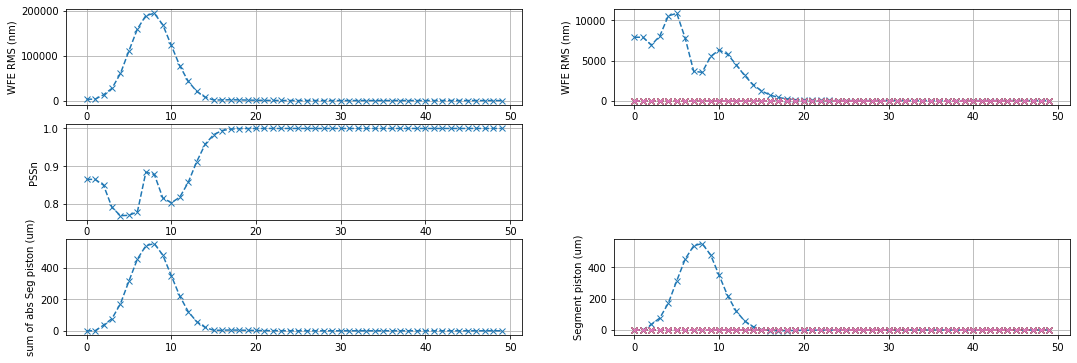

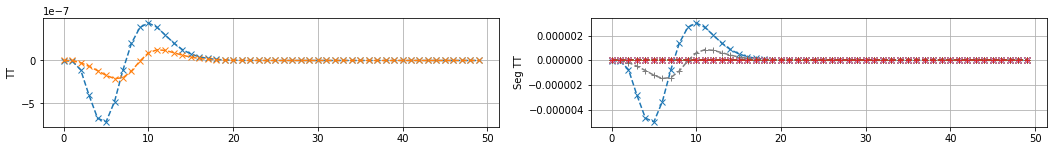

In [24]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

Bending mode load test - Baseline reconstructor with saturation $k_i=0.25$ (without noise)


Final values:
 WFE (nm): [ 711701.40291] 
 [ 1840760.34930  0.77174  0.77181  0.77278  0.77266  0.77111  0.17256] 
PSSn: [ 0.79925] 
sum of abs seg piston (um): 374.3555362943907 
 [-374.35288 -0.00072  0.00008  0.00062 -0.00012 -0.00061 -0.00050]


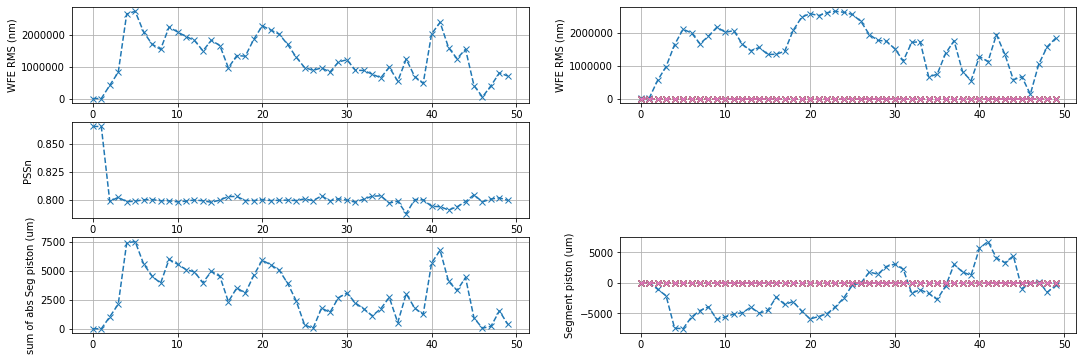

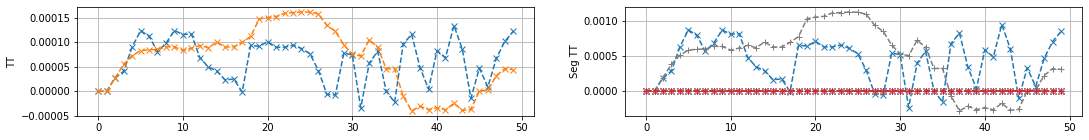

In [33]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

### Controller outputs and aberration inducing loads

(Random) RBM load test - Baseline reconstructor without saturation $k_i=0.25$ (without noise)

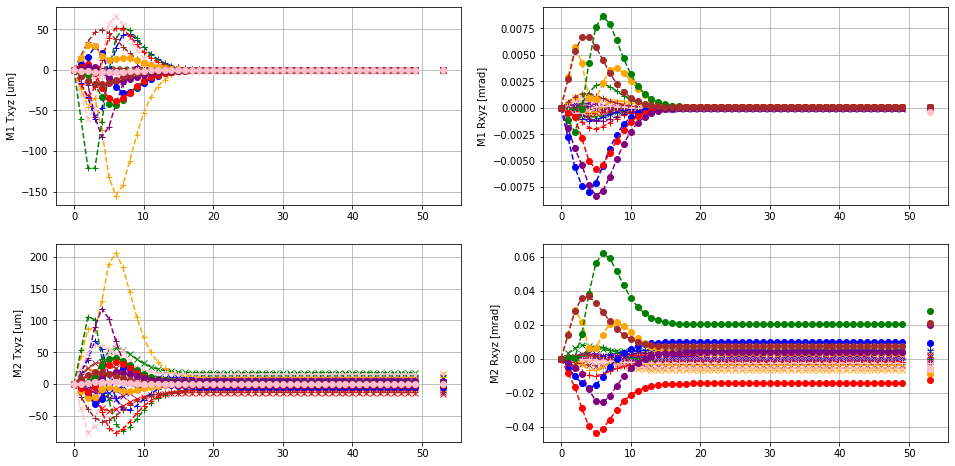

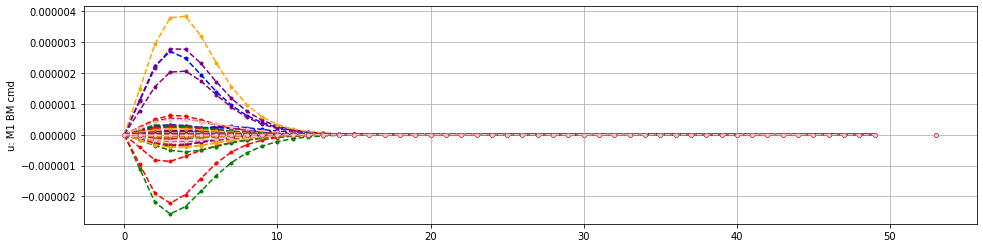

In [17]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

 (Random) RBM load test - Baseline reconstructor with saturation $k_i=0.25$ (without noise)

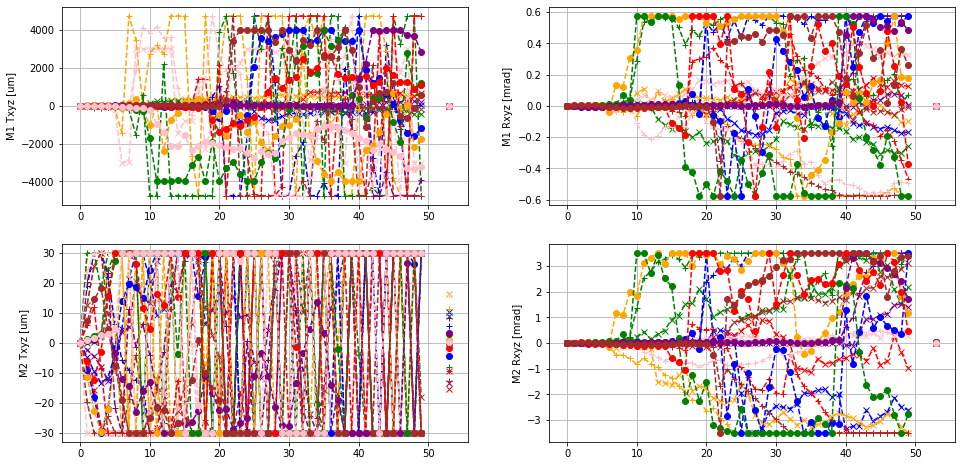

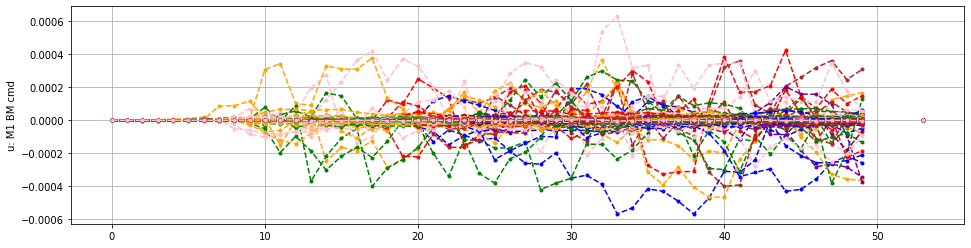

In [10]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

Bending mode load test - Baseline reconstructor without saturation $k_i=0.25$ (without noise)

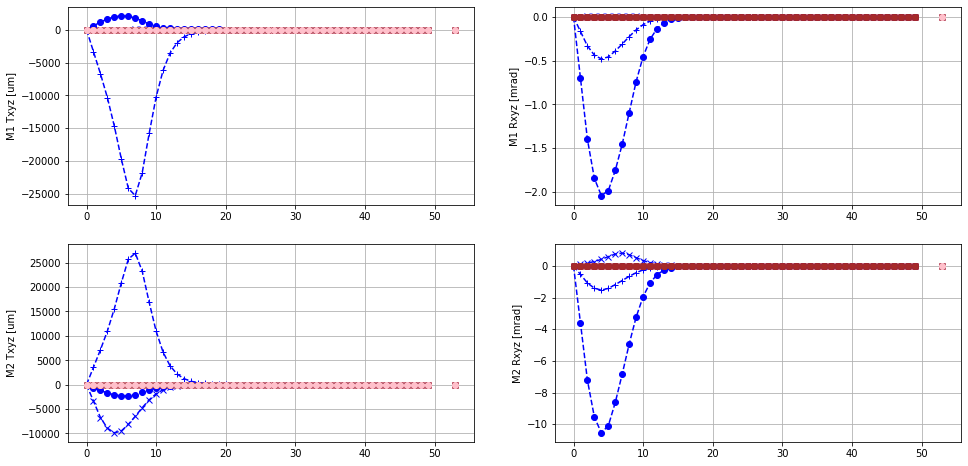

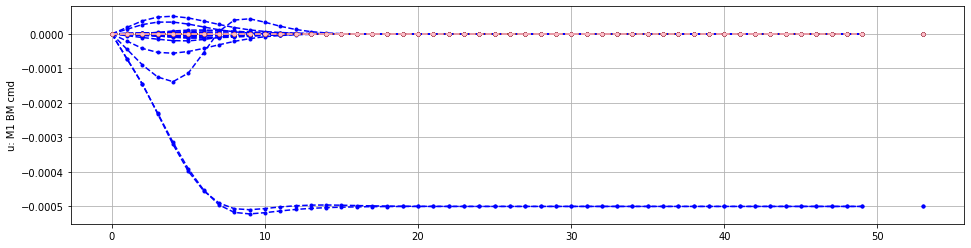

In [26]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

Bending mode load test - Baseline reconstructor with saturation $k_i=0.25$ (without noise)

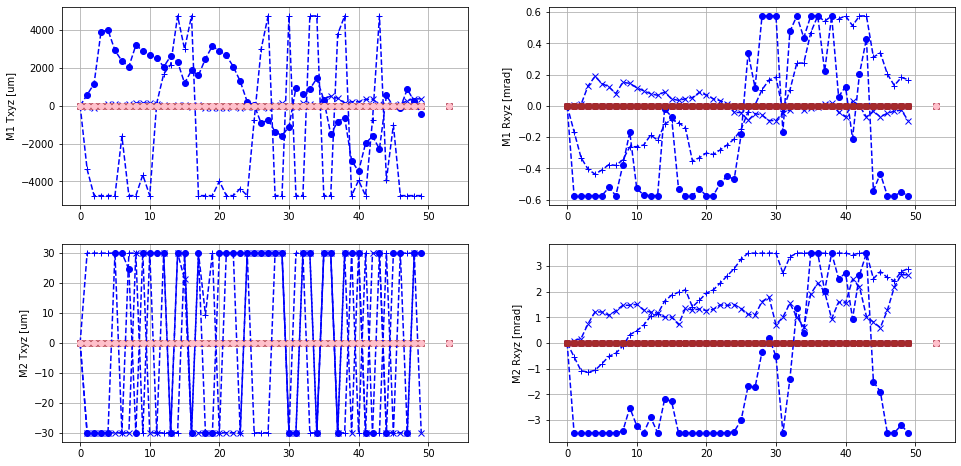

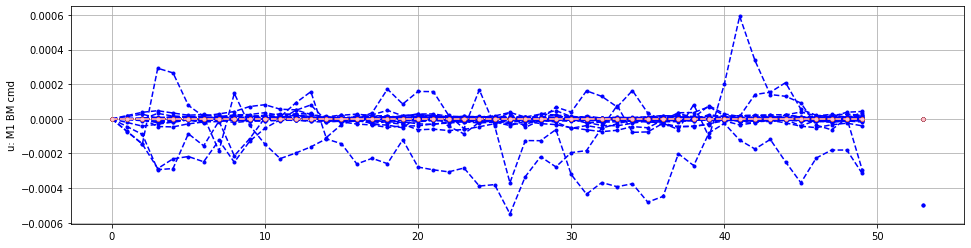

In [34]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

In [ ]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

In [ ]:
import scipy.io
if 'CG2HP' not in locals():
    CG2HP = scipy.io.loadmat('../ActiveOptics/CG2HP.mat')

In [ ]:
U = sim.logs.entries['SHAcO']
#CG2HP['CG2HP_d'][0][0].shape
import matplotlib.pyplot as plt

m1_hp_d = []
for kk in range(7):
    m1TxyzRxyz = np.split(np.hstack([U['M1 Txyz'].timeSeries[1],
                                     U['M1 Rxyz'].timeSeries[1]]),7,axis=0)
    m1_hp_d.append(np.squeeze(CG2HP['CG2HP_d'][0][kk].dot(m1TxyzRxyz[kk])))
    plt.plot(m1_hp_d[kk].T*1.0e3,'.--', color = colors[kk])
plt.ylabel('HP length [mm]')
plt.xlabel('Iteration')
plt.grid()    

In [ ]:
3.5e-6*(180/np.pi)*3600

In [ ]:
# Test cases in which REQ-L4-M1S-51833 seems misleading, according 
#to the CG2HP matrix of build3 fem
M1RBMmax = np.array([3.0e-3,4.75e-3,4.0e-3,650e-6,575e-6,575e-6])
print('HP lengths',CG2HP['CG2HP_d'][0][0].dot(M1RBMmax)*1.0e3)

M1RBMmax = np.array([3.0e-3,4.75e-3,4.0e-3,0*650e-6,0*575e-6,575e-6])
print('HP lengths',CG2HP['CG2HP_d'][0][0].dot(M1RBMmax)*1.0e3)

In [ ]:
np.array([[0.38, 40],[3, 330]])/3600*(np.pi/180)

### Actuator force test

 (Random) RBM load test - Baseline reconstructor without saturation $k_i=0.25$ (without noise)

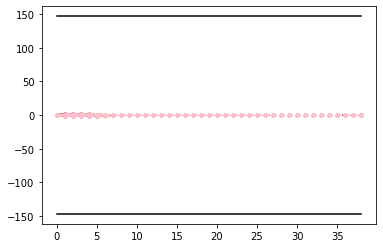

In [19]:
import matplotlib.pyplot as plt

BM_ = sim.logs.entries['SHAcO']['M1 BM'].timeSeries
k_max = 40

for kseg in range(6):
    plt.plot(bm2Fz_oa.dot(BM_[1][kseg,:,1:k_max]).T,'--.',color=colors[kseg])
plt.plot(bm2Fz_cs.dot(BM_[1][6,:,1:k_max]).T,'--.',color=colors[6])
plt.plot(max_Fz*np.ones(BM_[0][1:k_max].shape),'k')
plt.plot(-max_Fz*np.ones(BM_[0][1:k_max].shape),'k')
plt.show()

 (Random) RBM load test - Baseline reconstructor with saturation $k_i=0.25$ (without noise)

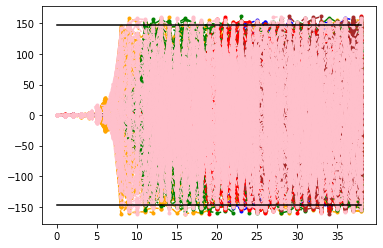

In [11]:
import matplotlib.pyplot as plt

BM_ = sim.logs.entries['SHAcO']['M1 BM'].timeSeries
k_max = 40

for kseg in range(6):
    plt.plot(bm2Fz_oa.dot(BM_[1][kseg,:,1:k_max]).T,'--.',color=colors[kseg])
plt.plot(bm2Fz_cs.dot(BM_[1][6,:,1:k_max]).T,'--.',color=colors[6])
plt.plot(max_Fz*np.ones(BM_[0][1:k_max].shape),'k')
plt.plot(-max_Fz*np.ones(BM_[0][1:k_max].shape),'k')
plt.show()

Bending mode load test - Baseline reconstructor without saturation $k_i=0.25$ (without noise)

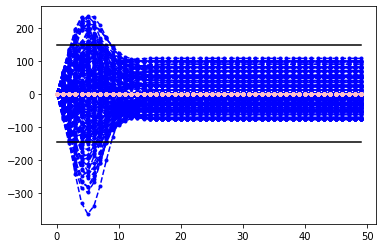

In [25]:
import matplotlib.pyplot as plt

BM_ = sim.logs.entries['SHAcO']['M1 BM'].timeSeries
for kseg in range(6):
    plt.plot(bm2Fz_oa.dot(BM_[1][kseg,:,:]).T,'--.',color=colors[kseg])
plt.plot(bm2Fz_cs.dot(BM_[1][6,:,:]).T,'--.',color=colors[6])
plt.plot(max_Fz*np.ones(BM_[0].shape),'k')
plt.plot(-max_Fz*np.ones(BM_[0].shape),'k')
plt.show()

Bending mode load test - Baseline reconstructor with saturation $k_i=0.25$ (without noise)

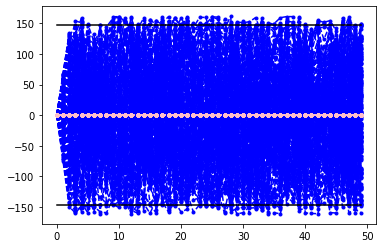

In [35]:
import matplotlib.pyplot as plt

BM_ = sim.logs.entries['SHAcO']['M1 BM'].timeSeries
for kseg in range(6):
    plt.plot(bm2Fz_oa.dot(BM_[1][kseg,:,:]).T,'--.',color=colors[kseg])
plt.plot(bm2Fz_cs.dot(BM_[1][6,:,:]).T,'--.',color=colors[6])
plt.plot(max_Fz*np.ones(BM_[0].shape),'k')
plt.plot(-max_Fz*np.ones(BM_[0].shape),'k')
plt.show()

In [ ]:
#U_sat.shape, Fz2bm.shape, bm_sat.shape
_U,s_oa,V_oaT = np.linalg.svd(Afz['outer'],0)
isigma = np.zeros_like(s_oa)
n_bm = 27
isigma[:n_bm] = 1/s_oa[:n_bm]

T1 = np.dot(V_oaT.T, np.diag(isigma))
T2 = np.dot(np.diag(s_oa),V_oaT)
print('norm of I-T1*T2: %0.4g'%np.linalg.norm(np.eye(165)-T1.dot(T2)))

U_ = bm2Fz_oa.dot(BM_[1][0,:,4])
U_sat = np.clip(U_, -np.array([max_Fz]*bm2Fz_oa.shape[0]), np.array([max_Fz]*bm2Fz_oa.shape[0]))
bm_sat = T2.dot(U_sat)
bm_sat_reg = np.zeros_like(s_oa)
bm_sat_reg[:n_bm] = bm_sat[:n_bm]
max(U_sat), max(U_), max(T1.dot(bm_sat))

In [ ]:
plt.semilogy(np.abs(bm_sat),'.')
plt.semilogy(np.abs(bm_sat_reg),'x')